<a href="https://colab.research.google.com/github/Lameuta/PlayAroundWithKanVision/blob/main/Untitled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
from typing import List, Tuple, Union
import torch.nn.functional as FU
import math
import matplotlib.pyplot as plt
import tqdm
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import os
from PIL import Image
from torchvision.datasets.imagenet import parse_devkit_archive, parse_train_archive, parse_val_archive

In [2]:
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
    #split = "balanced"
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
    #split= "balanced"
)

100%|██████████| 26421880/26421880 [00:00<00:00, 112576578.41it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 4350702.28it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 13079015.84it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19992849.07it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [3]:
device = "cuda"

In [4]:
# Credits to: https://github.com/detkov/Convolution-From-Scratch/
import torch
import numpy as np
from typing import List, Tuple, Union

def calc_out_dims(matrix, kernel_side, stride, dilation, padding):
    batch_size, n_channels, n, m = matrix.shape
    h_out = np.floor((n + 2 * padding[0] - kernel_side - (kernel_side - 1) * (dilation[0] - 1)) / stride[0]).astype(int) + 1
    w_out = np.floor((m + 2 * padding[1] - kernel_side - (kernel_side - 1) * (dilation[1] - 1)) / stride[1]).astype(int) + 1
    return h_out, w_out, batch_size, n_channels

def kan_conv2d(matrix: Union[List[List[float]], np.ndarray], #but as torch tensors. Kernel side asume q el kernel es cuadrado
             kernel,
             kernel_side,
             stride= (1, 1),
             dilation= (1, 1),
             padding= (0, 0),
             device= "cuda"
             ) -> torch.Tensor:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (batch_size, colors, n, m]): 2D matrix to be convolved.
        kernel  (function]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    h_out, w_out,batch_size,n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)

    matrix_out = torch.zeros((batch_size,n_channels,h_out,w_out)).to(device)#estamos asumiendo que no existe la dimension de rgb
    unfold = torch.nn.Unfold((kernel_side,kernel_side), dilation=dilation, padding=padding, stride=stride)


    for channel in range(n_channels):
        #print(matrix[:,channel,:,:].unsqueeze(1).shape)
        conv_groups = unfold(matrix[:,channel,:,:].unsqueeze(1)).transpose(1, 2)
        #print("conv",conv_groups.shape)
        for k in range(batch_size):
            matrix_out[k,channel,:,:] = kernel.forward(conv_groups[k,:,:]).reshape((h_out,w_out))
    return matrix_out

def multiple_convs_kan_conv2d(matrix, #but as torch tensors. Kernel side asume q el kernel es cuadrado
             kernels,
             kernel_side,
             stride= (1, 1),
             dilation= (1, 1),
             padding= (0, 0),
             device= "cuda"
             ) -> torch.Tensor:
    """Makes a 2D convolution with the kernel over matrix using defined stride, dilation and padding along axes.

    Args:
        matrix (batch_size, colors, n, m]): 2D matrix to be convolved.
        kernel  (function]): 2D odd-shaped matrix (e.g. 3x3, 5x5, 13x9, etc.).
        stride (Tuple[int, int], optional): Tuple of the stride along axes. With the `(r, c)` stride we move on `r` pixels along rows and on `c` pixels along columns on each iteration. Defaults to (1, 1).
        dilation (Tuple[int, int], optional): Tuple of the dilation along axes. With the `(r, c)` dilation we distancing adjacent pixels in kernel by `r` along rows and `c` along columns. Defaults to (1, 1).
        padding (Tuple[int, int], optional): Tuple with number of rows and columns to be padded. Defaults to (0, 0).

    Returns:
        np.ndarray: 2D Feature map, i.e. matrix after convolution.
    """
    h_out, w_out,batch_size,n_channels = calc_out_dims(matrix, kernel_side, stride, dilation, padding)
    n_convs = len(kernels)
    matrix_out = torch.zeros((batch_size,n_channels*n_convs,h_out,w_out)).to(device)#estamos asumiendo que no existe la dimension de rgb
    unfold = torch.nn.Unfold((kernel_side,kernel_side), dilation=dilation, padding=padding, stride=stride)
    conv_groups = unfold(matrix[:,:,:,:]).view(batch_size, n_channels,  kernel_side*kernel_side, h_out*w_out).transpose(2, 3)#reshape((batch_size,n_channels,h_out,w_out))
    for channel in range(n_channels):
        for kern in range(n_convs):
            matrix_out[:,kern  + channel*n_convs,:,:] = kernels[kern].conv.forward(conv_groups[:,channel,:,:].flatten(0,1)).reshape((batch_size,h_out,w_out))
    return matrix_out


In [5]:

class ConvReLUKANLayer(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 g: int,
                 k: int,
                 n_convs: int = 1,
                 kernel_size: tuple = (3, 3),
                 stride: tuple = (1, 1),
                 padding: tuple = (1, 1),
                 dilation: tuple = (1, 1)):
        super(ConvReLUKANLayer, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.g = g
        self.k = k
        self.n_convs = n_convs
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        # Initialize the start (S) and end (E) matrices as trainable parameters
        self.S = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))
        self.E = nn.Parameter(torch.linspace(0, 1, g + k).repeat(in_channels, 1))

        # Initialize the convolution layers
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels if i == 0 else out_channels, out_channels, kernel_size, stride, padding, dilation)
            for i in range(n_convs)
        ])

        # Weight matrix Wc for the final convolution step
        #self.Wc = nn.Parameter(torch.randn(out_channels, g + k))

        # Normalization constant r
        #self.r = 16 * g ** 4 / (k + 1) ** 4

    def forward(self, x):
      self.device = x.device
      if self.n_convs>1:
          return multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
      return self.convs[0].forward(x)




In [6]:
class KAN_Convolution(torch.nn.Module):
    def __init__(
            self,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            scale_noise: float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device = "cpu"
        ):
        """
        Args
        """
        super(KAN_Convolution, self).__init__()
        self.grid_size = grid_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        # self.device = device
        self.conv = KANLinear(
            in_features = math.prod(kernel_size),
            out_features = 1,
            grid_size=grid_size,
            scale_noise=scale_noise,
            scale_base=scale_base,
            scale_spline=scale_spline,
            base_activation=base_activation,
            grid_eps=grid_eps,
            grid_range=grid_range
        )

    def forward(self, x: torch.Tensor, update_grid=False):
        self.device = x.device
        return kan_conv2d(x, self.conv,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum( layer.regularization_loss(regularize_activation, regularize_entropy) for layer in self.layers)

In [7]:
class ReLUKANLayer(nn.Module):
    def __init__(self, input_size: int, g: int, k: int, output_size: int, train_ab: bool = True):
        super().__init__()
        self.g, self.k, self.r = g, k, 4*g*g / ((k+1)*(k+1))
        self.input_size, self.output_size = input_size, output_size
        phase_low = np.arange(-k, g) / g
        phase_height = phase_low + (k+1) / g
        self.phase_low = nn.Parameter(torch.Tensor(np.array([phase_low for i in range(input_size)])),
                                      requires_grad=train_ab)
        self.phase_height = nn.Parameter(torch.Tensor(np.array([phase_height for i in range(input_size)])),
                                         requires_grad=train_ab)
        self.equal_size_conv = nn.Conv2d(1, output_size, (g+k, input_size))
    def forward(self, x):
        x1 = torch.relu(x - self.phase_low)
        x2 = torch.relu(self.phase_height - x)
        x = x1 * x2 * self.r
        x = x * x
        x = x.reshape((len(x), 1, self.g + self.k, self.input_size))
        x = self.equal_size_conv(x)
        x = x.reshape((len(x), self.output_size, 1))
        return x

In [8]:
import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid_e = torch.linspace(grid_range[0] + h, grid_range[1], grid_size).expand(in_features, -1)
        grid_s = torch.linspace(grid_range[0], grid_range[1] - h, grid_size).expand(in_features, -1)
        self.register_buffer("grid_e", grid_e)
        self.register_buffer("grid_s", grid_s)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features, grid_size))
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(torch.Tensor(out_features, in_features))

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (torch.rand(self.grid_size, self.in_features, self.out_features) - 0.5)
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                self.scale_spline * self.curve2coeff(self.grid_e.T, noise)
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def r_basis(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the R_i basis functions for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: R_i basis tensor of shape (batch_size, in_features, grid_size).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid_e: torch.Tensor = self.grid_e  # (in_features, grid_size)
        grid_s: torch.Tensor = self.grid_s  # (in_features, grid_size)

        x = x.unsqueeze(-1)  # (batch_size, in_features, 1)

        # Calculate ReLU(e_i - x) and ReLU(x - s_i)
        relu_e = torch.relu(grid_e - x)  # (batch_size, in_features, grid_size)
        relu_s = torch.relu(x - grid_s)  # (batch_size, in_features, grid_size)

        # Compute the R_i(x) basis functions
        r_basis = (relu_e * relu_s) ** 2 * 16 / (grid_e - grid_s) ** 4

        assert r_basis.size() == (x.size(0), self.in_features, self.grid_size)
        return r_basis.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.r_basis(x).transpose(0, 1)  # (in_features, batch_size, grid_size)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(A, B).solution  # (in_features, grid_size, out_features)
        result = solution.permute(2, 0, 1)  # (out_features, in_features, grid_size)

        assert result.size() == (self.out_features, self.in_features, self.grid_size)
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        #assert x.dim() == 2 and x.size(1) == self.in_features

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.r_basis(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        return base_output + spline_output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.r_basis(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # Sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(self.grid_size + 1, dtype=torch.float32, device=x.device).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive

        self.grid_e.copy_(grid.T[:-1])
        self.grid_s.copy_(grid.T[1:])
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

    def regularization_loss(self):
        total_loss = 0.0
        for layer in self.layers:
            total_loss += layer.regularization_loss()
        return total_loss


In [9]:
class KAN_Convolutional_Layer(torch.nn.Module):
    def __init__(
            self,
            n_convs: int = 1,
            kernel_size: tuple = (2,2),
            stride: tuple = (1,1),
            padding: tuple = (0,0),
            dilation: tuple = (1,1),
            grid_size: int = 5,
            scale_noise:float = 0.1,
            scale_base: float = 1.0,
            scale_spline: float = 1.0,
            base_activation=torch.nn.SiLU,
            grid_eps: float = 0.02,
            grid_range: tuple = [-1, 1],
            device: str = "cpu"
        ):
        """
        Kan Convolutional Layer with multiple convolutions

        Args:
            n_convs (int): Number of convolutions to apply
            kernel_size (tuple): Size of the kernel
            stride (tuple): Stride of the convolution
            padding (tuple): Padding of the convolution
            dilation (tuple): Dilation of the convolution
            grid_size (int): Size of the grid
            spline_order (int): Order of the spline
            scale_noise (float): Scale of the noise
            scale_base (float): Scale of the base
            scale_spline (float): Scale of the spline
            base_activation (torch.nn.Module): Activation function
            grid_eps (float): Epsilon of the grid
            grid_range (tuple): Range of the grid
            device (str): Device to use
        """


        super(KAN_Convolutional_Layer, self).__init__()
        self.grid_size = grid_size
        self.kernel_size = kernel_size
        # self.device = device
        self.dilation = dilation
        self.padding = padding
        self.convs = torch.nn.ModuleList()
        self.n_convs = n_convs
        self.stride = stride


        # Create n_convs KAN_Convolution objects
        for _ in range(n_convs):
            self.convs.append(
                KAN_Convolution(
                    kernel_size= kernel_size,
                    stride = stride,
                    padding=padding,
                    dilation = dilation,
                    grid_size=grid_size,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                    # device = device ## changed device to be allocated as per the input device for pytorch DDP
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        # If there are multiple convolutions, apply them all
        self.device = x.device
        if self.n_convs>1:
            return multiple_convs_kan_conv2d(x, self.convs,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

        # If there is only one convolution, apply it
        return kan_conv2d(x, self.convs,self.kernel_size[0],self.stride,self.dilation,self.padding,self.device)

In [15]:
class ConvReLUKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = KAN_Convolutional_Layer(
            n_convs = 2,
            kernel_size= (3,3),
            device = device,
            grid_size=10
        )

        self.conv2 = KAN_Convolutional_Layer(
            n_convs = 2,
            kernel_size = (3,3),
            device = device,
            grid_size=10
        )
        
        self.pool1 = nn.MaxPool2d(
            kernel_size=(3, 3),
            stride = 2,
        )
        
        self.conv3 = KAN_Convolutional_Layer(
            n_convs = 4,
            kernel_size = (3,3),
            device = device,
            grid_size=10
        )
         
        self.conv4 = KAN_Convolutional_Layer(
            n_convs = 4,
            kernel_size = (3,3),
            device = device,
            grid_size=10
        )
        
        self.conv5 = KAN_Convolutional_Layer(
            n_convs = 4,
            kernel_size = (3,3),
            device = device,
            grid_size=10
        )
        
        
        
        


        self.flat = nn.Flatten()
        # Adjust the in_features based on the size of the flattened output
        self.kan1 = KANLinear(
            1024,
            256,
            grid_size=10,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )
        self.kan2 = KANLinear(
            256,
            10,
            grid_size=10,
            scale_noise=0.01,
            scale_base=1,
            scale_spline=1,
            base_activation=nn.SiLU,
            grid_eps=0.02,
            grid_range=[0,1],
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool1(x)


        x = self.flat(x)
        x = self.kan1(x)
        x = self.kan2(x)
        # = self.linear2(x)
        x = FU.log_softmax(x, dim=1)
        return x

In [22]:
from torch.cuda.amp import GradScaler
def train_and_test(model, train_loader, test_loader, num_epochs, device, save_path='best_model.pth'):
    # Loss Function and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_test_accuracy = 0.0  # Track the best test accuracy
    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.autocast(device_type="cuda"):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        # Testing/Validation Phase
        model.eval()
        running_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Testing'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        test_loss = running_loss / total_test
        test_accuracy = correct_test / total_test

        # Print Results After Each Epoch
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}\n')

        # Save the model if it has the best test accuracy
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            torch.save(model.state_dict(), save_path)
            print(f'Best model saved with test accuracy: {best_test_accuracy:.4f}\n')

In [12]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 256

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7afea2689cc0>, <torch.utils.data.dataloader.DataLoader object at 0x7afea26888b0>)
Length of train dataloader: 235 batches of 256
Length of test dataloader: 40 batches of 256


In [13]:
!export PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

In [23]:
# Assuming the model and data loaders are defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = ConvReLUKAN()
model.to(device)



# Train and Test the model
train_and_test(model, train_dataloader, test_dataloader, num_epochs=25, device=device)

/tmp/ipykernel_36/3822837902.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


cuda


Epoch 1/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


Epoch 1/25
Test Loss: 0.5940, Test Accuracy: 0.7804

Best model saved with test accuracy: 0.7804



Epoch 2/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.63it/s]


Epoch 2/25
Test Loss: 0.4806, Test Accuracy: 0.8286

Best model saved with test accuracy: 0.8286



Epoch 3/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.68it/s]


Epoch 3/25
Test Loss: 0.4464, Test Accuracy: 0.8403

Best model saved with test accuracy: 0.8403



Epoch 4/25 - Testing: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]


Epoch 4/25
Test Loss: 0.4198, Test Accuracy: 0.8485

Best model saved with test accuracy: 0.8485



Epoch 5/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


Epoch 5/25
Test Loss: 0.4141, Test Accuracy: 0.8487

Best model saved with test accuracy: 0.8487



Epoch 6/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.51it/s]


Epoch 6/25
Test Loss: 0.3890, Test Accuracy: 0.8595

Best model saved with test accuracy: 0.8595



Epoch 7/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.47it/s]


Epoch 7/25
Test Loss: 0.4038, Test Accuracy: 0.8521



Epoch 8/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Epoch 8/25
Test Loss: 0.3708, Test Accuracy: 0.8663

Best model saved with test accuracy: 0.8663



Epoch 9/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


Epoch 9/25
Test Loss: 0.3766, Test Accuracy: 0.8665

Best model saved with test accuracy: 0.8665



Epoch 10/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.61it/s]


Epoch 10/25
Test Loss: 0.3662, Test Accuracy: 0.8701

Best model saved with test accuracy: 0.8701



Epoch 11/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s]


Epoch 11/25
Test Loss: 0.3703, Test Accuracy: 0.8692



Epoch 12/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s]


Epoch 12/25
Test Loss: 0.3544, Test Accuracy: 0.8717

Best model saved with test accuracy: 0.8717



Epoch 13/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


Epoch 13/25
Test Loss: 0.3638, Test Accuracy: 0.8708



Epoch 14/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


Epoch 14/25
Test Loss: 0.3643, Test Accuracy: 0.8711



Epoch 15/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.67it/s]


Epoch 15/25
Test Loss: 0.3724, Test Accuracy: 0.8690



Epoch 16/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.59it/s]


Epoch 16/25
Test Loss: 0.3528, Test Accuracy: 0.8728

Best model saved with test accuracy: 0.8728



Epoch 17/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.62it/s]


Epoch 17/25
Test Loss: 0.3609, Test Accuracy: 0.8695



Epoch 18/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.64it/s]


Epoch 18/25
Test Loss: 0.3445, Test Accuracy: 0.8784

Best model saved with test accuracy: 0.8784



Epoch 19/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.59it/s]


Epoch 19/25
Test Loss: 0.3457, Test Accuracy: 0.8791

Best model saved with test accuracy: 0.8791



Epoch 20/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.69it/s]


Epoch 20/25
Test Loss: 0.3823, Test Accuracy: 0.8595



Epoch 21/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s]


Epoch 21/25
Test Loss: 0.3574, Test Accuracy: 0.8700



Epoch 22/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


Epoch 22/25
Test Loss: 0.3504, Test Accuracy: 0.8748



Epoch 23/25 - Testing: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]


Epoch 23/25
Test Loss: 0.3370, Test Accuracy: 0.8818

Best model saved with test accuracy: 0.8818



Epoch 24/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.65it/s]


Epoch 24/25
Test Loss: 0.3534, Test Accuracy: 0.8749



Epoch 25/25 - Testing: 100%|██████████| 40/40 [00:07<00:00,  5.66it/s]

Epoch 25/25
Test Loss: 0.3661, Test Accuracy: 0.8713



In [24]:
labels_list=test_data.classes
labels_list

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [25]:
# Load the state_dict
state_dict = torch.load('best_model.pth', weights_only=True)

# Instantiate the model
best_model = ConvReLUKAN()

# Manually assign weights to model layers
with torch.no_grad():
    for name, param in best_model.named_parameters():
        if name in state_dict:
            if name == "conv1.convs.0.conv.grid_e":
                param.copy_(state_dict[name].clone())  # Clone the problematic parameter
            else:
                param.copy_(state_dict[name])  # Copy other parameters normally

# Now you can proceed with your evaluation code
best_model.to(device)
best_model.eval()

y_preds = []

# Disable gradient calculation during inference
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send input data and targets to the appropriate device
        X, y = X.to(device), y.to(device)
        
        # Perform the forward pass (prediction)
        y_logit = best_model(X)
        
        # Convert logits to probabilities and then get the predicted class labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        
        # Move the predictions back to the CPU and append to the list
        y_preds.append(y_pred.cpu())

# Concatenate the list of predictions into a single tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 40/40 [00:06<00:00,  5.72it/s]


mlxtend version: 0.23.1
0.23.1
625.0


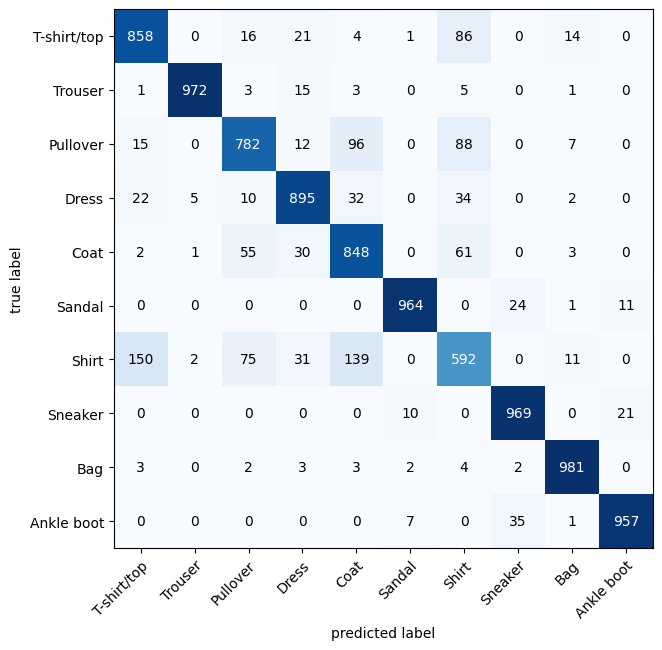

In [26]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets

all_targets = []
for _, label in test_data:
    all_targets.append(label)
all_targets = torch.tensor(all_targets)

# Ensure preds is a tensor
y_pred_tensor = y_pred_tensor.clone().detach()
print(len(all_targets)/16)
# Setup the confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(labels_list), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=all_targets)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # matplotlib likes working with NumPy
    class_names=labels_list,  # turn the row and column labels into class names
    figsize=(10, 7)
)

In [27]:
pytorch_total_params = sum(p.numel() for p in best_model.parameters() if p.requires_grad == True)
print(pytorch_total_params)

3178176


In [28]:
best_model

ConvReLUKAN(
  (conv1): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-1): 2 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv2): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-1): 2 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (pool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-3): 4 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv4): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-3): 4 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): SiLU()
        )
      )
    )
  )
  (conv5): KAN_Convolutional_Layer(
    (convs): ModuleList(
      (0-3): 4 x KAN_Convolution(
        (conv): KANLinear(
          (base_activation): S